# Gesture Recognition with CNN

This notebook demonstrates training a CNN on a subset of the HaGRID dataset and using it to classify new gesture images, plotting and saving a confusion matrix.

In [21]:
import cv2
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomContrast
from keras.metrics import categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob
from typing import Dict

# Configuration
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)
COLOR_CHANNELS = 3
PATH = "../gesture_dataset_sample"
CONDITIONS = ["like", "dislike", "stop", "peace", "rock"]

In [22]:
# Helper function to preprocess images

def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

In [23]:
# Load training data and annotations
images = []
labels = []
label_names = []

for condition in CONDITIONS:
    with open(f"{PATH}/_annotations/{condition}.json") as f:
        annotations = json.load(f)
    for filename in os.listdir(f"{PATH}/{condition}"):
        UID = filename.split(".")[0]
        img = cv2.imread(f"{PATH}/{condition}/{filename}")
        if img is None or UID not in annotations:
            continue
        annotation = annotations[UID]
        for i, bbox in enumerate(annotation["bboxes"]):
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            label = annotation["labels"][i]
            if label not in label_names:
                label_names.append(label)
            label_index = label_names.index(label)
            images.append(preprocessed)
            labels.append(label_index)

In [24]:
# Prepare data for training
X = np.array(images).astype("float32") / 255.
y = np.array(labels)
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
y_one_hot = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

In [25]:
# Build and train the CNN model
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = "relu"
activation_conv = "leaky_relu"
layer_count = 2
num_neurons = 64

model = Sequential()
model.add(RandomFlip("horizontal"))
model.add(RandomContrast(0.1))
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding="same"))
model.add(MaxPooling2D(pool_size=(4, 4), padding="same"))
model.add(Conv2D(32, (5, 5), activation=activation_conv, padding="same"))
model.add(MaxPooling2D(pool_size=(3, 3), padding="same"))
model.add(Conv2D(32, (3, 3), activation=activation_conv, padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model.add(Dropout(0.2))
model.add(Flatten())
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))
model.add(Dense(num_neurons, activation=activation))
model.add(Dense(num_classes, activation="softmax"))
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=["accuracy"])
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor="val_loss", patience=3)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50


d:\Projects\Uni\ITT\assignment-05-cnn-realdegrees-1\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1887 - loss: 1.8034 - val_accuracy: 0.2178 - val_loss: 1.7921 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2386 - loss: 1.7931 - val_accuracy: 0.2699 - val_loss: 1.7393 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3227 - loss: 1.6805 - val_accuracy: 0.3620 - val_loss: 1.5455 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4161 - loss: 1.4453 - val_accuracy: 0.6288 - val_loss: 1.1076 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5774 - loss: 1.0688 - val_accuracy: 0.6411 - val_loss: 0.9742 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6692 - loss: 0.8822 - val_accuracy: 0.7331 - val_loss: 0.7148 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7811 - loss: 0.6115 - val_

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


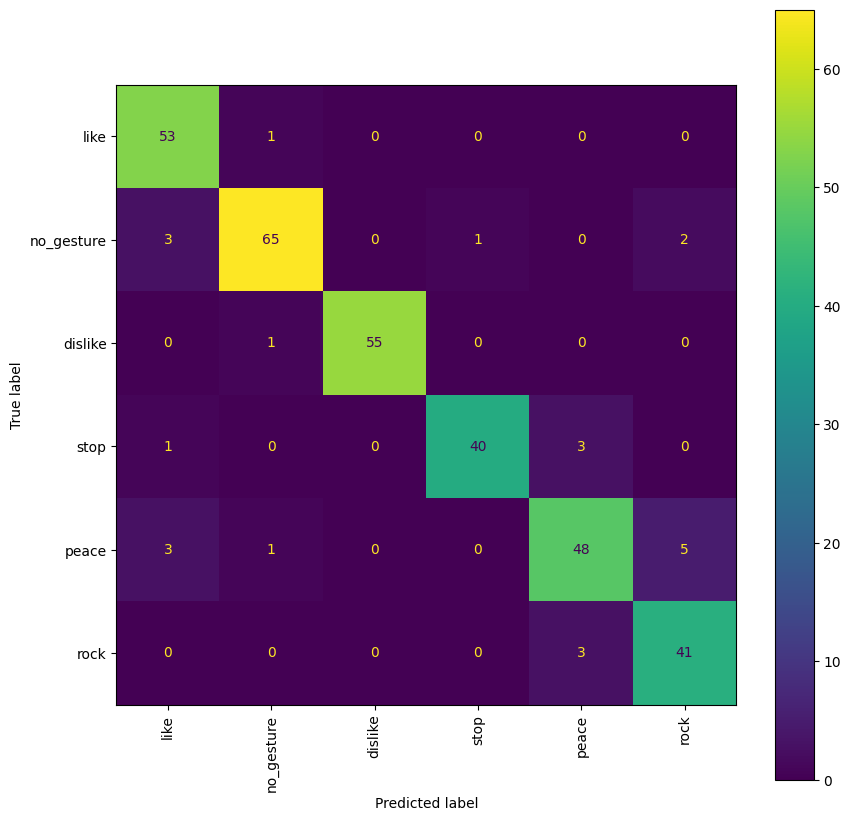

In [26]:
# Evaluate and plot confusion matrix on test set
y_test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test_labels, y_pred)
fig = plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())
plt.xticks(rotation=90, ha="center")
plt.show()

# Predict and Evaluate on New Images

This section loads images from the `GESTURES_PATH` directory, predicts their classes using the trained CNN, compares predictions to ground truth from the annotation file, and plots/saves the confusion matrix as `conf-matrix.png`.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


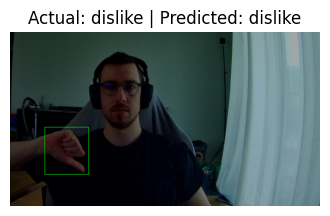

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


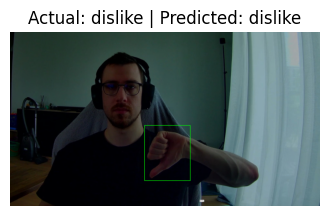

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


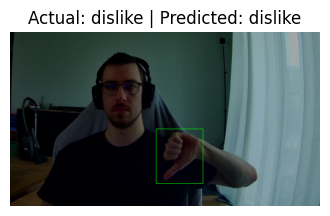

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


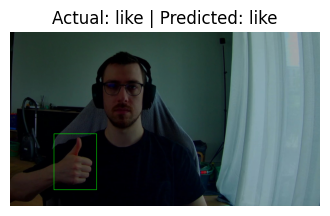

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


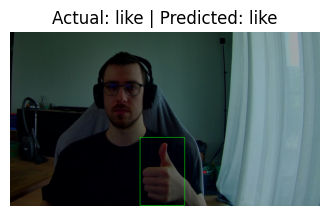

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


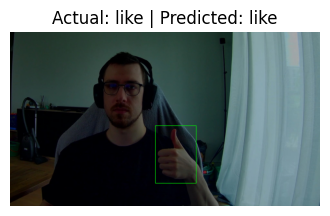

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


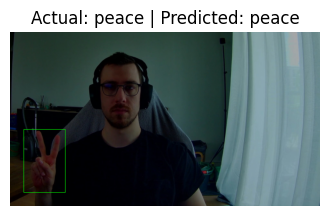

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


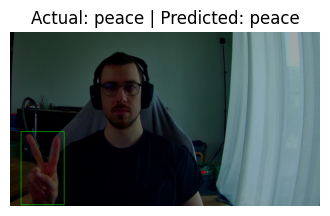

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


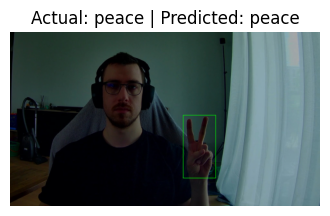

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


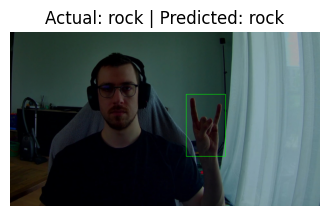

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


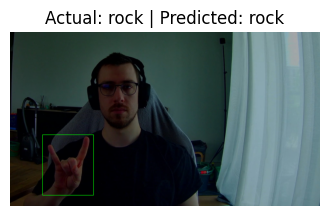

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


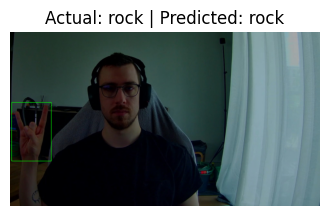

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


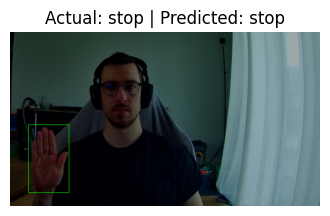

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


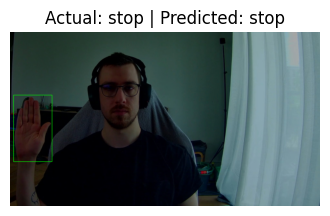

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


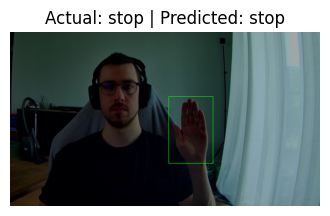

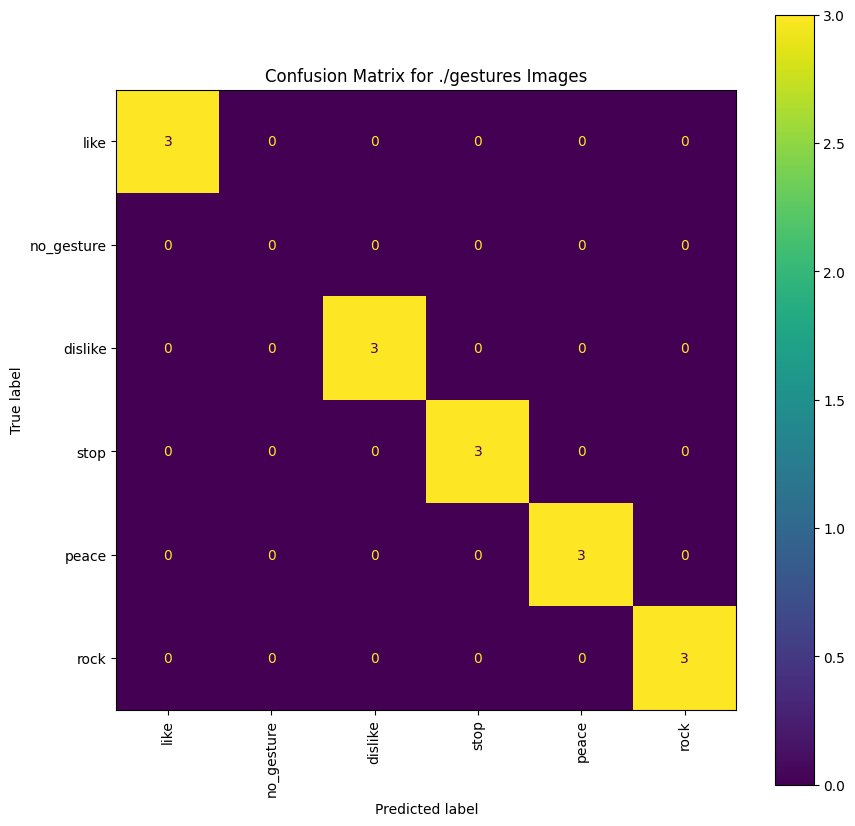

In [27]:

# Prepare lists for predictions and ground truth
predictions = []
ground_truths = []
GESTURES_PATH = "./gestures"
ANNOTATION_PATH = "./annot-*.json"

annot_files = glob.glob(ANNOTATION_PATH)
assert len(annot_files) > 0, "No annotation file found."
with open(annot_files[0], "r") as f:
    gesture_annots: Dict[str, Dict] = json.load(f)

for fname, annot in gesture_annots.items():
    if not annot["labels"]:
        continue
    label = annot["labels"][0]
    if label not in label_names:
        continue
    label_idx = label_names.index(label)
    # Load image from gestures subfolders
    img_candidates = glob.glob(os.path.join(GESTURES_PATH, "**", fname + ".jpg"), recursive=True)
    if img_candidates:
        img_path = img_candidates[0]
    else:
        continue
    img = cv2.imread(img_path)
    if img is None:
        continue
    
    # Draw bounding box
    img_print = img.copy()
    bbox = annot["bboxes"][0]
    h, w = img.shape[:2]
    x1 = int(bbox[0] * w)
    y1 = int(bbox[1] * h)
    bw = int(bbox[2] * w)
    bh = int(bbox[3] * h)
    x2 = x1 + bw
    y2 = y1 + bh
    cv2.rectangle(img_print, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
    # Crop the image to the bounding box
    img = img[y1:y2, x1:x2]    
        
    # Use preprocess_image for consistency with training
    img = preprocess_image(img)
    img = np.expand_dims(img, axis=0)
    
    # Predict label
    pred = int(np.argmax(model.predict(img), axis=1)[0])
    pred_label = label_names[pred]
    predictions.append(pred)
    ground_truths.append(label_idx)
    
    # Print and show image with labels
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img_print, cv2.COLOR_BGR2RGB))
    plt.title(f"Actual: {label} | Predicted: {pred_label}")
    plt.axis("off")
    plt.show()
    
    

# Plot and save confusion matrix
if predictions and ground_truths:
    conf_matrix = confusion_matrix(ground_truths, predictions, labels=list(range(len(label_names))))
    fig = plt.figure(figsize=(10, 10))
    ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())
    plt.xticks(rotation=90, ha="center")
    plt.title(f"Confusion Matrix for {GESTURES_PATH} Images")
    plt.savefig("conf-matrix.png")
    plt.show()
else:
    print("No predictions or ground truth labels available.")